In [1]:
#import page
import gym
import numpy as np
from stable_baselines import SAC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

total_episodes = 100000
ac_dim = 1
ob_dim = 2
x_dim = 2*ob_dim+ac_dim



In [3]:
#test mountaincar-ddpg
from stable_baselines.ddpg.policies import MlpPolicy
from stable_baselines.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise, AdaptiveParamNoiseSpec
from stable_baselines import DDPG

model = DDPG.load("ddpg_mountain")
env = gym.make('NoisyMountainCarContinuous-v0')


record_dones = np.zeros(100)
steps_records = np.zeros(100) 
for outercount in range(100):  
    obs = env.reset()
    for dd in range(800):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        if dones:
            record_dones[outercount] = 1
            steps_records[outercount] = dd
            break
    if record_dones[outercount] == 0:
        steps_records[outercount] = 800
success_rate = np.sum(record_dones)/100
avg_steps = np.sum(steps_records)/100

print(success_rate)
print(avg_steps)


from winsound import Beep
Beep(3000, 500)

e verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Flatten.call of <tensorflow.python.layers.core.Flatten object at 0x0000029496C1AF98>>: AttributeError: module 'gast' has no attribute 'Num'
1.0
69.3


In [ ]:
#generate dataset
import gym
import numpy as np
from stable_baselines import DDPG

#we should get normal transitions, and add noise as samples
#pendulum obs: cos(theta), sin(theta), thetadot, action: 1

model = DDPG.load("ddpg_mountain")
env = gym.make('NoisyMountainCarContinuous-v0')
obs = env.reset()
acvariant = np.random.rand(total_episodes)
cor_dataset_xraw = np.zeros((total_episodes,x_dim))
cor_dataset_y = np.zeros((total_episodes,ob_dim))

subcount = 0
for dd in range(total_episodes):
    action, states = model.predict(obs)
    action = action + acvariant[dd]
    cor_dataset_xraw[dd][0:ob_dim] = obs
    cor_dataset_xraw[dd][ob_dim:ob_dim+ac_dim] = action
    obs, rewards, dones, info = env.step(action)
    cor_dataset_xraw[dd][ob_dim+ac_dim:2*ob_dim+ac_dim] = obs
    cor_dataset_y[dd][:] = obs

    subcount = subcount + 1
    if subcount >= 100:
        subcount = 0
        obs = env.reset()

np.save("mtn_x_raw.npy",cor_dataset_xraw)
np.save("mtn_y.npy",cor_dataset_y)

from winsound import Beep
Beep(3000, 500)

In [ ]:
#add random noises 
noisy_pos = 0.8*np.random.rand(1000)-0.4
noisy_spd = 0.06*np.random.rand(1000)-0.03
Xraw = np.load("mtn_x_raw.npy")
Yraw = np.load("mtn_y.npy")

X = np.zeros((total_episodes,x_dim))
newY = np.zeros((total_episodes,ob_dim))
for outer in range(1000):
    for inner in range(100):
        count = outer*100 + inner
        X[count][0] = Xraw[count][0]+noisy_pos[outer]
        X[count][1] = Xraw[count][1]+noisy_spd[outer]
        X[count][2] = Xraw[count][2]
        X[count][3] = Xraw[count][3]+noisy_pos[outer]
        X[count][4] = Xraw[count][4]+noisy_spd[outer]
np.save("mtn_x.npy",X)
from winsound import Beep
Beep(3000, 500)

In [ ]:
#train neural network

input_size = x_dim
output_size = 2

x_train = np.load("mtn_x.npy")
y_train = np.load("mtn_y.npy")

model = Sequential()
model.add(Dense(64, input_dim = input_size, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(output_size,activation = None))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

model.fit(x_train,y_train,epochs = 500, batch_size = 128)

model.save('mtn_denoise_1.h5') 
from winsound import Beep
Beep(3000, 500)

In [5]:
#test performance
import gym
import numpy as np

from stable_baselines import DDPG

env = gym.make('NoisyMountainCarContinuous-v0')
dcs_model=DDPG.load("ddpg_mountain")
den_model=load_model('mtn_denoise_1.h5')
obs_raw = env.reset()
obs_fix = obs_raw
env.change_env(0.012)
sub_reward_fix=[]
for dd in range(400):
    action, _states = dcs_model.predict(obs_fix)
    obac = np.append(obs_raw,action)
    obs_raw, rewards, dones, info = env.step(action)
    inputx = np.append(obac, obs_raw)
    inputx = inputx.reshape((1,5))
    obs_delta = den_model.predict(inputx)
    obs_fix = obs_delta.flatten()
    sub_reward_fix.append(rewards)

sub_reward_raw=[]
obs = env.reset()
for dd in range(400):
    action, _states = dcs_model.predict(obs)
    obs, rewards, dones, info = env.step(action)  
    sub_reward_raw.append(rewards)

from winsound import Beep
Beep(3000, 500)

g, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Flatten.call of <tensorflow.python.layers.core.Flatten object at 0x0000020D92B4D860>>: AttributeError: module 'gast' has no attribute 'Num'


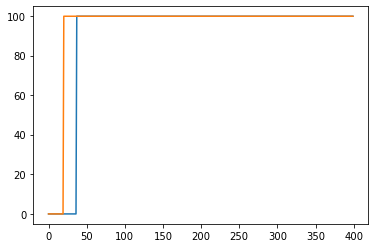

In [6]:
import matplotlib.pyplot as plt

plt.plot(range(400),np.array(sub_reward_raw))
plt.plot(range(400),np.array(sub_reward_fix))
plt.show()


In [ ]:
#system test
env = gym.make('NoisyMountainCarContinuous-v0')
dcs_model=DDPG.load("ddpg_mountain")
den_model=load_model('mtn_denoise_1.h5')

spd_noise = [0.02,0.03,0.04,0.05]
pos_noise = [0.2,0.3,0.4,0.5]
ac_noise = [0.2,0.4,0.6,0.8]
env_para = [0.0005,0.00075,0.006,0.012]
total_record_fix = []
total_record_raw = []
for gg in range(4):
    #fix
    env.change_env(env_para[gg])
    record_dones = np.zeros(100)
    steps_records = np.zeros(100)
    for outercnt in range(100):
        obs_raw = env.reset()
        obs_fix = obs_raw
        for dd in range(500):
            action, _states = dcs_model.predict(obs_fix)
            obac = np.append(obs_raw,action)
            obs_raw, rewards, dones, info = env.step(action)
            inputx = np.append(obac, obs_raw)
            inputx = inputx.reshape((1,5))
            obs_delta = den_model.predict(inputx)
            obs_fix = obs_delta.flatten()
            if dones:
                record_dones[outercnt] = 1
                steps_records[outercnt] = dd
                break
        if record_dones[outercnt] == 0:
            steps_records[outercnt] = 500
    success_rate = np.sum(record_dones)/100
    avg_steps = np.sum(steps_records)/100   
    total_record_fix.append([success_rate,avg_steps])
    #raw
    record_dones = np.zeros(100)
    steps_records = np.zeros(100)
    for outercnt in range(100):
        obs = env.reset()
        for dd in range(500):
            action, states = dcs_model.predict(obs)
            obs, rewards, dones, info = env.step(action)
            if dones:
                record_dones[outercnt] = 1
                steps_records[outercnt] = dd
                break
        if record_dones[outercnt] == 0:
            steps_records[outercnt] = 500
    success_rate = np.sum(record_dones)/100
    avg_steps = np.sum(steps_records)/100   
    total_record_raw.append([success_rate,avg_steps])

print('finish!')
from winsound import Beep
Beep(3000, 500)

In [ ]:
draw_raw = np.array(total_reward_raw)
draw_fix = np.array(total_reward_fix)

import matplotlib.pyplot as plt
fig=plt.figure()
fig.suptitle("noised vs denoised-action noise")

sbp1=plt.subplot(2,2,1)
plt.plot(range(400),draw_raw[0,:])
plt.plot(range(400),draw_fix[0,:])
sbp1.set_title("n = 0.4")

sbp2=plt.subplot(2,2,2)
plt.plot(range(400),draw_raw[1,:])
plt.plot(range(400),draw_fix[1,:])
sbp2.set_title("n = 0.8")

sbp3=plt.subplot(2,2,3)
plt.plot(range(400),draw_raw[2,:])
plt.plot(range(400),draw_fix[2,:])
sbp3.set_title("n = 1.0")

sbp4=plt.subplot(2,2,4)
plt.plot(range(400),draw_raw[3,:])
plt.plot(range(400),draw_fix[3,:])
sbp4.set_title("n = 1.2")

plt.subplots_adjust(hspace=0.6,wspace=0.4)
plt.show()